In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'/Users/jakubzmujdzin/Desktop/repo/luna-nlp-paper/predictions_for_thresholds_0.005_to_0.3.csv')

## Plots for each threshold

In [3]:
tmp = []
for threshold in np.linspace(0.005, 0.3, num=60):
    thrsh_df = df[round(df.threshold, 3) == round(threshold, 3)]
    thrsh_df = thrsh_df.sort_values(by='accuracy', ascending=False)
    tmp.append(thrsh_df.iloc[0,].values)

In [4]:
best_preds_for_each_threshold = pd.DataFrame(tmp, columns=df.columns)
best_preds_for_each_threshold = best_preds_for_each_threshold[best_preds_for_each_threshold.threshold <= 0.25]

## Naive negative predictions for all intervals for whole month

In [5]:
date_start, date_end = "01/05/22", "31/05/22"
interval_list = ["5Min", "15Min", "1H", "4H"]

In [6]:
from tools.ftx_price_data import GetFTXPriceData
import re
def interval_match(interval) -> str:
    """Match intervals (FTX and pandas use differently expressed intervals)"""
    return (
        re.findall(r"(\d+)(\w+?)", interval)[0][0]
        + " "
        + re.findall(r"(\d+)(\w+?)", interval)[0][1].lower()
    )
def get_adj_prices(interval) -> pd.DataFrame:
    """Retrieve price data and whether the price went up"""
    return (
        GetFTXPriceData(
            interval_match(interval), date_start, date_end
        )
        .get_candlestick_data()
        .assign(
            price_up=lambda x: x.apply(
                lambda col: 1 if (col["open"] < col["close"]) else -1, axis=1
            )
        )
        .set_index("date")
    )

def get_confusion_matrix(interval) -> dict:
    """Retrieve confusion matrix for certain prediction"""
    df = get_adj_prices(interval)[
        ["price_up"]
    ]
    df["real_pred"] = -1
    df = (
        df
    ).assign(
        tp=lambda x: x.apply(
            lambda u: 1
            if (u["real_pred"] == u["price_up"]) & (u["real_pred"] == 1)
            else 0,
            axis=1,
        ),
        tn=lambda x: x.apply(
            lambda u: 1
            if (u["real_pred"] == u["price_up"]) & (u["real_pred"] == -1)
            else 0,
            axis=1,
        ),
        fp=lambda x: x.apply(
            lambda u: 1 if (u["real_pred"] == 1) & (u["price_up"] == -1) else 0,
            axis=1,
        ),
        fn=lambda x: x.apply(
            lambda u: 1 if (u["real_pred"] == -1) & (u["price_up"] == 1) else 0,
            axis=1,
        ),
    )
    return {
        "tp": np.sum(df["tp"]),
        "fn": np.sum(df["fn"]),
        "fp": np.sum(df["fp"]),
        "tn": np.sum(df["tn"]),
    }

In [7]:
def calc_accuracy(conf_matrix: dict) -> float:
    return (conf_matrix["tp"] + conf_matrix["tn"]) / sum(conf_matrix.values())

def calc_recall(conf_matrix: dict) -> float:
    return conf_matrix["tp"] / (conf_matrix["fn"] + conf_matrix["tp"])

def calc_precision(conf_matrix: dict) -> float:
    return conf_matrix["tp"] / (conf_matrix["fp"] + conf_matrix["tp"])

def calc_f1_score(recall: float, precision: float) -> float:
    return (2 * recall * precision) / (recall + precision)

def calc_false_ommision_rate(conf_matrix: dict) -> float:
    return conf_matrix["fn"] / (conf_matrix["fn"] + conf_matrix["tn"])

def calc_false_positive_rate(conf_matrix: dict) -> float:
    return conf_matrix["fp"] / (conf_matrix["fp"] + conf_matrix["tn"])

def calc_specificity(conf_matrix: dict) -> float:
    return conf_matrix["tn"] / (conf_matrix["tn"] + conf_matrix["fp"])

def calc_balanced_accuracy(recall: float, specificity: float) -> float:
    return (recall + specificity) / 2

In [8]:
def calc_conf_matrix_stats(interval) -> list:
    """Retrieve metrics for classification"""
    conf_matrix = get_confusion_matrix(interval)
    return [
        interval,
        "naive",
        calc_accuracy(conf_matrix),
        calc_precision(conf_matrix),
        calc_recall(conf_matrix),
        calc_f1_score(
            calc_recall(conf_matrix), calc_precision(conf_matrix)
        ),
        calc_false_ommision_rate(conf_matrix),
        calc_false_positive_rate(conf_matrix),
        calc_specificity(conf_matrix),
        calc_balanced_accuracy(calc_recall(conf_matrix), calc_specificity(conf_matrix))
    ]

In [9]:
naive_df = pd.DataFrame([calc_conf_matrix_stats(interval) for interval in interval_list], columns=[
            "interval",
            "method",
            "accuracy",
            "precision",
            "recall",
            "f1_score",
            "false_ommision_rate",
            "false_positive_rate",
            "specificity",
            "balanced_accuracy"
        ])

/Users/jakubzmujdzin/Desktop/repo/luna-nlp-paper/tools/ftx_price_data.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df.drop_duplicates()[
<ipython-input-7-168b0caa6458>:8: RuntimeWarning: invalid value encountered in long_scalars
  return conf_matrix["tp"] / (conf_matrix["fp"] + conf_matrix["tp"])


In [10]:
naive_df.fillna(0).sort_values(by='accuracy', ascending=False)

,interval,method,accuracy,precision,recall,f1_score,false_ommision_rate,false_positive_rate,specificity,balanced_accuracy
3,4H,naive,0.616883,0.0,0.0,0.0,0.383117,0.0,1.0,0.5
2,1H,naive,0.565854,0.0,0.0,0.0,0.434146,0.0,1.0,0.5
1,15Min,naive,0.542090,0.0,0.0,0.0,0.457910,0.0,1.0,0.5
0,5Min,naive,0.520138,0.0,0.0,0.0,0.479862,0.0,1.0,0.5


In [11]:
best_preds_for_each_threshold['balanced_accuracy'] = (best_preds_for_each_threshold['recall'] + best_preds_for_each_threshold['specificity'])/2
best_preds_for_each_threshold.sort_values(by='accuracy', ascending=False).head(5)

,Unnamed: 0,interval,lag,method,accuracy,precision,recall,f1_score,false_ommision_rate,false_positive_rate,specificity,threshold,balanced_accuracy
48,19,4H,4,bert,0.750000,0.666667,0.800000,0.727273,0.166667,0.285714,0.714286,0.245,0.757143
47,19,4H,4,bert,0.750000,0.666667,0.800000,0.727273,0.166667,0.285714,0.714286,0.240,0.757143
45,19,4H,4,bert,0.733333,0.625000,0.833333,0.714286,0.142857,0.333333,0.666667,0.230,0.750000
44,19,4H,4,bert,0.733333,0.625000,0.833333,0.714286,0.142857,0.333333,0.666667,0.225,0.750000
49,19,4H,4,bert,0.727273,0.666667,0.800000,0.727273,0.200000,0.333333,0.666667,0.250,0.733333


/Users/jakubzmujdzin/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jakubzmujdzin/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jakubzmujdzin/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

Text(0.5, 1.0, 'May predictions')

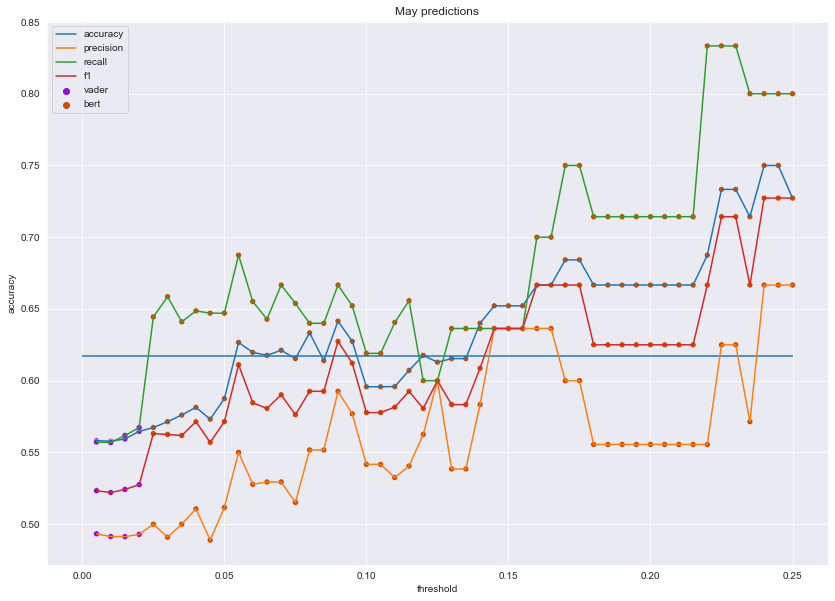

In [12]:
plt.figure(figsize=(14, 10))
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.accuracy)
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.precision)
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.recall)
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.f1_score)
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.accuracy, hue=best_preds_for_each_threshold.method, palette='gnuplot', label='_nolegend_')
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.precision, hue=best_preds_for_each_threshold.method, palette='gnuplot', label='_nolegend_')
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.recall, hue=best_preds_for_each_threshold.method, palette='gnuplot', label='_nolegend_')
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.f1_score, hue=best_preds_for_each_threshold.method, palette='gnuplot', label='_nolegend_')
plt.hlines(y=np.max(naive_df.accuracy), xmin=0, xmax=0.25)
plt.legend(('accuracy', 'precision', 'recall', 'f1', 'vader', 'bert'))
plt.title('May predictions')

## Naive negative predictions for all intervals for 05-14.05.22

In [13]:
df = pd.read_csv(r'/Users/jakubzmujdzin/Desktop/repo/luna-nlp-paper/short_predictions_for_thresholds_0.005_to_0.3.csv')
tmp = []
for threshold in np.linspace(0.005, 0.3, num=60):
    thrsh_df = df[round(df.threshold, 3) == round(threshold, 3)]
    thrsh_df = thrsh_df.sort_values(by='accuracy', ascending=False)
    tmp.append(thrsh_df.iloc[0,].values)
best_preds_for_each_threshold = pd.DataFrame(tmp, columns=df.columns)
best_preds_for_each_threshold = best_preds_for_each_threshold[best_preds_for_each_threshold.threshold <= 0.16]

In [14]:
date_start, date_end = "05/05/22", "14/05/22"
interval_list = ["5Min", "15Min", "1H", "4H"]
naive_df = pd.DataFrame([calc_conf_matrix_stats(interval) for interval in interval_list], columns=[
            "interval",
            "method",
            "accuracy",
            "precision",
            "recall",
            "f1_score",
            "false_ommision_rate",
            "false_positive_rate",
            "specificity",
            "balanced_accuracy"
        ]).fillna(0)

/Users/jakubzmujdzin/Desktop/repo/luna-nlp-paper/tools/ftx_price_data.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df.drop_duplicates()[
<ipython-input-7-168b0caa6458>:8: RuntimeWarning: invalid value encountered in long_scalars
  return conf_matrix["tp"] / (conf_matrix["fp"] + conf_matrix["tp"])


In [15]:
naive_df.sort_values(by='accuracy', ascending=False)

,interval,method,accuracy,precision,recall,f1_score,false_ommision_rate,false_positive_rate,specificity,balanced_accuracy
3,4H,naive,0.722222,0.0,0.0,0.0,0.277778,0.0,1.0,0.5
2,1H,naive,0.622120,0.0,0.0,0.0,0.377880,0.0,1.0,0.5
1,15Min,naive,0.597688,0.0,0.0,0.0,0.402312,0.0,1.0,0.5
0,5Min,naive,0.569610,0.0,0.0,0.0,0.430390,0.0,1.0,0.5


In [16]:
best_preds_for_each_threshold['balanced_accuracy'] = (best_preds_for_each_threshold['recall'] +
                                                      best_preds_for_each_threshold['specificity']) / 2
best_preds_for_each_threshold.sort_values(by='accuracy', ascending=False).head(5)

,Unnamed: 0,interval,lag,method,accuracy,precision,recall,f1_score,false_ommision_rate,false_positive_rate,specificity,threshold,balanced_accuracy
26,3,4H,0,bert,0.916667,1.0,0.80,0.888889,0.125000,0.0,1.0,0.135,0.900
25,3,4H,0,bert,0.916667,1.0,0.80,0.888889,0.125000,0.0,1.0,0.130,0.900
24,3,4H,0,bert,0.916667,1.0,0.80,0.888889,0.125000,0.0,1.0,0.125,0.900
27,3,4H,0,bert,0.909091,1.0,0.75,0.857143,0.125000,0.0,1.0,0.140,0.875
30,3,4H,0,bert,0.900000,1.0,0.75,0.857143,0.142857,0.0,1.0,0.155,0.875


/Users/jakubzmujdzin/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jakubzmujdzin/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jakubzmujdzin/opt/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

Text(0.5, 1.0, 'Predictions for 05-14.05.22')

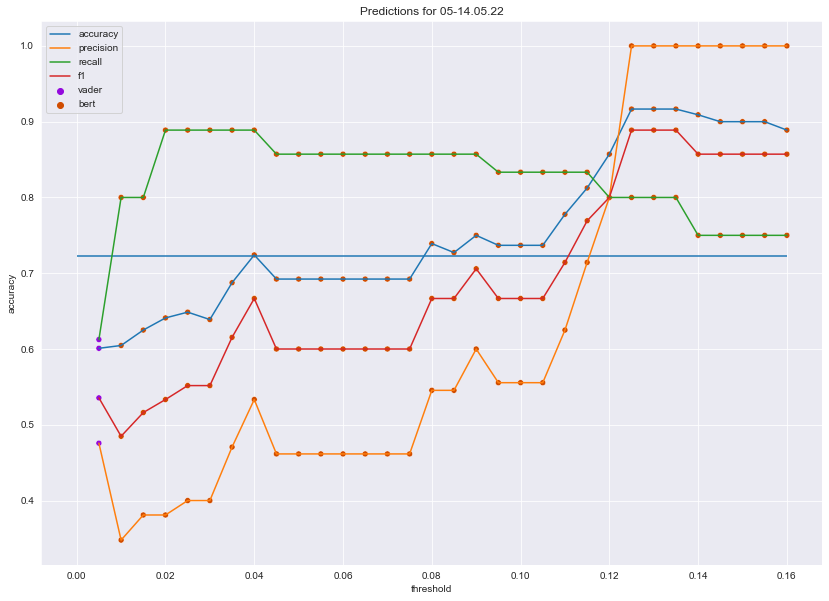

In [17]:
plt.figure(figsize=(14, 10))
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.accuracy)
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.precision)
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.recall)
plt.plot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.f1_score)
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.accuracy, hue=best_preds_for_each_threshold.method, palette='gnuplot', label='_nolegend_')
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.precision, hue=best_preds_for_each_threshold.method, palette='gnuplot', label='_nolegend_')
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.recall, hue=best_preds_for_each_threshold.method, palette='gnuplot', label='_nolegend_')
sns.scatterplot(best_preds_for_each_threshold.threshold, best_preds_for_each_threshold.f1_score, hue=best_preds_for_each_threshold.method, palette='gnuplot', label='_nolegend_')
plt.hlines(y=np.max(naive_df.accuracy), xmin=0, xmax=0.16)
plt.legend(('accuracy', 'precision', 'recall', 'f1', 'vader', 'bert'))
plt.title('Predictions for 05-14.05.22')